# Low-dose Residual Model 

TensorFlow example of a Residual Model proposed at this [Github page](https://github.com/WANG-AXIS/LdDMDenoising) to restore low-dose mammography. 

`Author: Rodrigo Vimieiro`

`Date: Feb, 2021`



<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/LAVI-USP/Machine-Learning/blob/master/"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/LAVI-USP/Machine-Learning/blob/master/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [ ]:
import tensorflow as tf
import functools
import matplotlib.pyplot as plt
import sys
import numpy as np

## Define MNIST help functions:

In [ ]:
class MNIST_Helper():
    
  def download(self):

    # Loads the MNIST dataset.
    (self.x_train, self.y_train) ,(self.x_test, self.y_test) =  tf.keras.datasets.mnist.load_data()

    self.train_dataset_shape = self.x_train.shape
    self.test_dataset_shape = self.x_test.shape


  def print_information(self):

    # Print informations about the MNIST dataset.
    print("There is %d training samples, containing images with shape of: %dx%d and %d channel" 
          % (self.train_dataset_shape[0],self.train_dataset_shape[1],self.train_dataset_shape[2],self.train_dataset_shape[3]))
    print("Train variable shape:", end='')
    print(self.train_dataset_shape)

  def pre_process(self):

    # Reshape to have 1 channel (last dimension) and normalize
    self.x_train = np.expand_dims(self.x_train, axis=-1).astype(np.float32)
    self.x_test = np.expand_dims(self.x_test, axis=-1).astype(np.float32)

    # Normalize data
    ## https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn
    self.x_train /= 255 #(self.x_train - 127.5) / 127.5
    self.x_test /= 255 #(self.x_test - 127.5) / 127.5

    self.train_dataset_shape = self.x_train.shape
    self.test_dataset = self.x_test.shape

  def noise_injection(self):

    # Gaussian noise
    self.x_train_noise = self.x_train + tf.random.normal(self.x_train.shape, mean=1, stddev=0.5, dtype=np.float32)
    self.x_test_noise = self.x_test + tf.random.normal(self.x_test.shape, mean=1, stddev=0.5, dtype=np.float32)

    self.x_train_noise = self.x_train_noise - np.min(self.x_train_noise) 
    self.x_train_noise /= np.max(self.x_train_noise)

    self.x_test_noise = self.x_test_noise - np.min(self.x_test_noise) 
    self.x_test_noise /= np.max(self.x_test_noise)

    #self.x_train_noise = np.clip(self.x_train_noise, 0, 1)
    #self.x_test_noise = np.clip(self.x_test_noise, 0, 1)
  
  def create_dataset_iterable(self):

    # Create database objects
    self.train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train_noise, self.x_train))
    self.test_dataset = tf.data.Dataset.from_tensor_slices((self.x_test_noise, self.x_test))
      
  def shuffle_dataset(self, dataset_size):
    
    return self.train_dataset.shuffle(dataset_size)

### Defining the Residual model:

In [ ]:
class BasicBlock_model(tf.keras.Model):

  def __init__(self):

    super(BasicBlock_model, self).__init__()
    
    self.n_filters = 64
    self.img_input_shape = (28,28,64) # nRows X nCols X nChannels

    self.BasicBlock = self.build_BasicBlock()

  def build_BasicBlock(self):

    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation=None, strides=1, use_bias=True)      
    BatchNormalization = tf.keras.layers.BatchNormalization
    ReLU = tf.keras.layers.ReLU
    ResAdd = tf.keras.layers.Add()

    imgBatch = tf.keras.layers.Input(shape=self.img_input_shape)

    Conv2D_1 = Conv2D(filters=self.n_filters, kernel_size=3)(imgBatch)
    Batch_1 = BatchNormalization()(Conv2D_1)
    ReLU_1 = ReLU()(Batch_1)
      
    Conv2D_2 = Conv2D(filters=self.n_filters, kernel_size=3)(ReLU_1)
    Batch_2 = BatchNormalization()(Conv2D_2)
    Res_1 = ResAdd([Batch_2, imgBatch])
    ReLU_2 = ReLU()(Res_1)

    model = tf.keras.Model(inputs=imgBatch, outputs=ReLU_2, name="BasicBlock")

    return model
  
  def call(self, x):

    return self.BasicBlock(x)

class GreatBlock_model(tf.keras.Model):

  def __init__(self):

    super(GreatBlock_model, self).__init__()
    
    self.n_filters = 64
    self.img_input_shape = (28,28,64) # nRows X nCols X nChannels

    self.BasicBlock_1 = BasicBlock_model()

    self.BasicBlock_2 = BasicBlock_model()

    self.GreatBlock = self.build_GreatBlock()

  def build_GreatBlock(self):

    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation=None, strides=1, use_bias=True)      
    ReLU = tf.keras.layers.ReLU
    ResAdd = tf.keras.layers.Add()

    imgBatch = tf.keras.layers.Input(shape=self.img_input_shape)

    BasicBlock_1 = self.BasicBlock_1(imgBatch)

    BasicBlock_2 = self.BasicBlock_2(BasicBlock_1)

    Res_1 = ResAdd([imgBatch, BasicBlock_2])

    ReLU_1 = ReLU()(Res_1)

    model = tf.keras.Model(inputs=imgBatch, outputs=[ReLU_1], name="GreatBlock")

    return model

  def call(self, x):

    return self.GreatBlock(x)

class residual_model(tf.keras.Model):

  def __init__(self):

    super(residual_model, self).__init__()
    
    self.n_filters = 64
    self.img_input_shape = (28,28,1) # nRows X nCols X nChannels

    self.GreatBlock_1 = GreatBlock_model()

    self.GreatBlock_2 = GreatBlock_model()

    self.resModel = self.build_ResModel()


  def build_ResModel(self):

    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation=None, strides=1, use_bias=True)      
    ReLU = tf.keras.layers.ReLU
    ResAdd = tf.keras.layers.Add()

    imgBatch = tf.keras.layers.Input(shape=self.img_input_shape)

    Conv2D_1 = Conv2D(filters=self.n_filters, kernel_size=3)(imgBatch)

    GreatBlock_1 = self.GreatBlock_1(Conv2D_1)

    GreatBlock_2 = self.GreatBlock_2(GreatBlock_1)

    Conv2D_2 = Conv2D(filters=1, kernel_size=3)(GreatBlock_2)

    Res_1 = ResAdd([imgBatch, Conv2D_2])

    ReLU_1 = ReLU()(Res_1)

    model = tf.keras.Model(inputs=imgBatch, outputs=[ReLU_1], name="ResModel")
    
    return model

  def call(self, x):

    return self.resModel(x)

### Defining the loss function:

In [ ]:
def loss_function(img_recon, img_without_noise):

    # MSE loss
    loss_MSE = tf.math.reduce_mean(tf.square(img_recon - img_without_noise))

    # Combination of both losses
    loss = loss_MSE 

    return loss

### Defining the optimizer:

In [ ]:
def create_optimizer(learning_rate):

  return tf.keras.optimizers.Adam(learning_rate, beta_1=0.5) # define our optimizer

### Defining the trainning step:

In [ ]:
@tf.function
def train_step(autoencoder, img_with_noise , img_without_noise, optimizer):

  with tf.GradientTape() as tape:
        
    # Feed images into autoencoder
    img_recon = autoencoder(img_with_noise)
        
    # Calc the loss
    loss = loss_function(img_recon, img_without_noise)

  ### Backpropagation ###
  # Get the gradients
  grads = tape.gradient(loss, autoencoder.trainable_variables)

  # Update the weights
  optimizer.apply_gradients(zip(grads, autoencoder.trainable_variables))

  return loss

### Defining the trainning loop:


In [ ]:
def train_model(autoencoder, dataset, num_epochs, batch_size, learning_rate):

  optimizer = create_optimizer(learning_rate)

  train_loss_history = []
  validation_loss_history = []

  metrics_names = ['train_loss','val_loss'] 
  
  # Loop on each epoch
  for epoch in range(num_epochs):

    print("\nepoch {}/{}".format(epoch+1,num_epochs))

    progBar = tf.keras.utils.Progbar(MNIST.train_dataset_shape[0], stateful_metrics=metrics_names)

    # Loop on each batch of train dataset
    for idX, (batch_x, batch_y) in enumerate(MNIST.train_dataset.batch(batch_size)): 
        
      # Train the model
      train_loss = train_step(autoencoder, batch_x, batch_y, optimizer)

      values=[('train_loss',train_loss)]

      progBar.update(idX*batch_size, values=values) 

      train_loss_history.append(tf.math.reduce_mean(train_loss))


    # Loop on each batch of test dataset for validation
    for batch_x, batch_y in MNIST.test_dataset.batch(batch_size):

      # Foward image through the network
      img_recon = autoencoder(batch_x)

      # Calc the loss
      val_loss = loss_function(img_recon, batch_y)

      validation_loss_history.append(tf.math.reduce_mean(val_loss))


    # Update progBar with val_loss
    values=[('train_loss',train_loss),('val_loss',val_loss)]

    progBar.update(MNIST.train_dataset_shape[0], values=values, finalize=True)


    # Shuffle train dataset for next epoch
    MNIST.train_dataset = MNIST.shuffle_dataset(MNIST.train_dataset_shape[0])
  
  train_loss = [train_loss_history[x].numpy() for x in range(0,len(train_loss_history),len(train_loss_history)//num_epochs)]
  val_loss = [validation_loss_history[x].numpy() for x in range(0,len(validation_loss_history),len(validation_loss_history)//num_epochs)]
  
  return train_loss, val_loss

-----------------------------------------------------------------------
## %% Main code %%

In [ ]:
# Create MNIST helper class
MNIST = MNIST_Helper()

# Download the dataset
MNIST.download()

# Pre processing
MNIST.pre_process()

# Display some dataset information
MNIST.print_information()

# Noise injection
MNIST.noise_injection()

# Create TF Dataset object 
MNIST.create_dataset_iterable()

There is 60000 training samples, containing images with shape of: 28x28 and 1 channel
Train variable shape:(60000, 28, 28, 1)


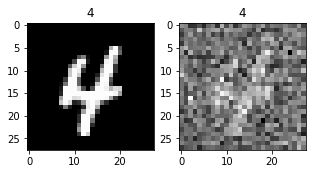

In [ ]:
### Examining the MNIST training dataset ###

idx_train_img = 18787 #@param {type:"slider", min:0, max:59999, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(MNIST.x_train[idx_train_img]),'gray')
plt.title(np.squeeze(MNIST.y_train[idx_train_img])); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(MNIST.x_train_noise[idx_train_img]),'gray')
plt.title(np.squeeze(MNIST.y_train[idx_train_img])); plt.grid(False)

In [ ]:
resModel = residual_model()

In [ ]:
# Training hyperparameters
num_epochs = 5
batch_size = 256
learning_rate = 1e-4

# Train the model 
train_loss, val_loss = train_model(resModel, MNIST, num_epochs, batch_size, learning_rate)


epoch 1/5
60000/60000 [==============================] - 36s 599us/step - train_loss: 0.0198 - val_loss: 0.0239

epoch 2/5
60000/60000 [==============================] - 33s 547us/step - train_loss: 0.0157 - val_loss: 0.0186

epoch 3/5
60000/60000 [==============================] - 32s 538us/step - train_loss: 0.0154 - val_loss: 0.0164

epoch 4/5
60000/60000 [==============================] - 33s 549us/step - train_loss: 0.0135 - val_loss: 0.0152

epoch 5/5
60000/60000 [==============================] - 32s 541us/step - train_loss: 0.0127 - val_loss: 0.0141


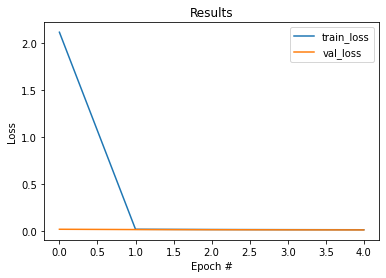

In [ ]:
# Plot loss results
N = np.arange(0, num_epochs)
plt.figure()
plt.plot(N, train_loss, label="train_loss")
plt.plot(N, val_loss, label="val_loss")
plt.title("Results")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

Text(0.5, 1.0, 'Reconstructed')

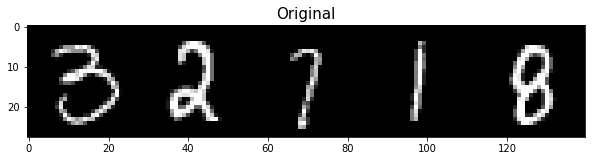

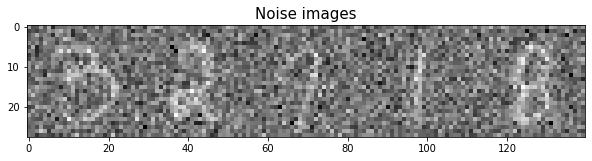

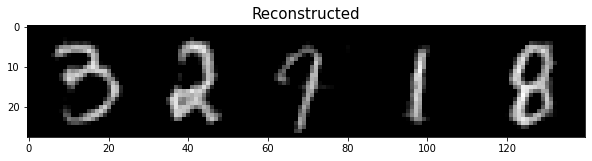

In [ ]:
idx_test_img = 173 #@param {type:"slider", min:0, max:9999, step:1}

img_test = MNIST.x_test_noise[idx_test_img:idx_test_img+5]

img_recon = resModel(img_test)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack(np.squeeze(MNIST.x_test[idx_test_img:idx_test_img+5])),'gray')
plt.title("Original", fontsize=15)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack(np.squeeze(img_test)),'gray')
plt.title("Noise images", fontsize=15)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack(np.squeeze(img_recon)),'gray')
plt.title("Reconstructed", fontsize=15)
